# Malware Detection

# Predicting Malware Executables using the EMBER Dataset

## Introduction

In this notebook, we aim to build a machine learning model capable of detecting malicious executable files (malware) using the **EMBER (Extensible Malware Benchmark) dataset**. The EMBER dataset is a widely used resource in the cybersecurity community for malware detection and analysis. It consists of features extracted from executable files, which can be used to train models to predict whether a given file is benign or malicious.

Malware detection plays a crucial role in cybersecurity, as malicious executables can cause significant harm to individuals and organizations. Traditional signature-based detection methods often fail to identify new, previously unseen malware variants. As a result, machine learning techniques have become increasingly popular for detecting malware based on the characteristics of executables.

## EMBER Dataset Overview

The EMBER dataset contains a collection of features extracted from Windows executable files. These features are numeric and represent various aspects of an executable, such as its structure, behavior, and interactions with the system. The dataset includes both **benign** and **malicious** executables, making it suitable for supervised learning tasks.

The EMBER dataset provides:
- **Features**: 2381-dimensional feature vectors representing the characteristics of each executable file.
- **Labels**: The target labels for classification, where:
  - `0` represents **benign** files,
  - `1` represents **malicious** files.
  - `-1` represents **unlabeled** files.

The goal of this notebook is to train a machine learning model on this dataset and predict whether a given executable is benign or malicious based on its features.

## Problem Statement

Given the vectorized feature data of an executable file, the task is to classify it into one of two categories:
- **Benign (0)**: The executable is safe and does not pose any threat.
- **Malicious (1)**: The executable is harmful and likely to be a malware.

Let’s begin by loading and exploring the dataset.

The ember dataset, which you can find [here](https://github.com/elastic/ember), consists of 6 jsonl files for training and one for testing. Opening one of them you will find a lot of json (one for each exe), with the below format. These are the features extracted from multiple executables.

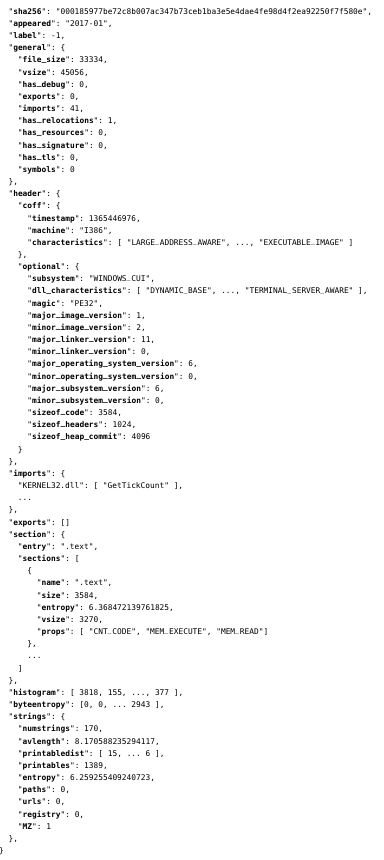

### Parsed features.

The dataset includes five groups of features that are extracted after parsing the PE file. LIEF names are used for strings that represent symbolic objects, such as characteristics and properties.

#### General file information.

The set of features in the general file information group includes the file size and basic information obtained from the PE header: the virtual size of the file, the number of imported and exported functions, whether the file has a debug section, thread local storage, resources, relocations, or a signature, and the number of symbols.

``` json
"general": 
    {
        "size": 3101705, // file size
        "vsize": 380928, // virtual file size
        "has_debug": 0, // if file has a debug section
        "exports": 0, // number of exported functions
        "imports": 156, // number of imported functions
        "has_relocations": 0, // if file has relocations
        "has_resources": 1, // if file has resources
        "has_signature": 0, // if file has a signature
        "has_tls": 0, // if file has a thread local storage
        "symbols": 0 // number of symbols
    }, 
```

#### Header information.

From the COFF and optional header the following informations are extracted.

##### What is **COFF**?
**COFF** (Common Object File Format) is a file format used to store executable files, object code, and libraries. It contains various headers that provide essential information about the file, such as machine architecture, timestamp, and version information, which helps operating systems and linkers understand how to use the file.

```json
"header": 
    {
    "coff": 
        {
            "timestamp": 1124149349, //When the file was created
            "machine": "I386", //The machine architecture (e.g., x86 or x64)
            "characteristics": ["CHARA_32BIT_MACHINE", "RELOCS_STRIPPED", "EXECUTABLE_IMAGE", "LINE_NUMS_STRIPPED", "LOCAL_SYMS_STRIPPED"] // A list of properties about the file (e.g., whether it’s relocatable)
        }, 
    "optional": 
        {
            "subsystem": "WINDOWS_GUI", // The system for which the file is intended (e.g., Windows)
            "dll_characteristics": [], // A list of dynamic-link library properties
            "magic": "PE32", // Identifies the file type
            "major_image_version": 0, 
            "minor_image_version": 0, 
            "major_linker_version": 7, 
            "minor_linker_version": 10, 
            "major_operating_system_version": 4, 
            "minor_operating_system_version": 0, 
            "major_subsystem_version": 4, 
            "minor_subsystem_version": 0, 
            "sizeof_code": 26624, //  Code size
            "sizeof_headers": 1024, // header size
            "sizeof_heap_commit": 4096 // commit size
        }
    },
```
For training the model, **feature hashing** is used to convert these string descriptors (like DLL characteristics, target machine) into numerical features, using 10 bins for each.

#### Imported functions.

The below represents a list of **imported functions** from various **Dynamic-Link Libraries (DLLs)** used by an executable. In Windows executables, **imports** are functions that the executable relies on from external libraries to perform certain operations.

The import address table is parsed, and the imported functions are reported by library. To create model features, the set of unique libraries is collected, and the **hashing trick** is used to sketch the set (256 bins). Similarly, the hashing trick (1024 bins) is applied to capture individual functions, represented as a string such as `library:FunctionName` pair (e.g., `kernel32.dll:CreateFileMappingA`).

##### What is the hashing trick?

The hashing trick, also known as feature hashing or **the hashing kernel, is a technique commonly used in machine learning, especially in natural language processing (NLP) and other domains with large feature spaces. It is used to reduce the dimensionality of data while retaining its key properties.


The hashing trick is a method of converting large, high-dimensional data (like strings, words, or other categorical features) into a fixed-size vector of lower dimensionality. Instead of storing the entire feature space, which could be huge and computationally expensive, the hashing trick uses a hash function to map each feature into a fixed number of bins (or buckets).

```json
"imports": {
    "KERNEL32.dll": ["SetFileTime", "CompareFileTime", "SearchPathA", ... , "MulDiv"], 
    "USER32.dll": ["CloseClipboard", "SetClipboardData", "EmptyClipboard", ... , "PostQuitMessage"], 
    "GDI32.dll": ["SetTextColor", "SetBkMode", "SetBkColor", ... , "GetDeviceCaps"], 
    "SHELL32.dll": ["SHFileOperationA", "SHGetSpecialFolderLocation", "SHGetMalloc", ... , "ShellExecuteA"], 
    "ADVAPI32.dll": ["RegEnumValueA", "RegSetValueExA", "RegQueryValueExA", ... , "RegDeleteKeyA", "RegCloseKey", "RegCreateKeyExA"], 
    "COMCTL32.dll": ["ImageList_AddMasked", "ImageList_Create", ... , "ordinal17"], 
    "ole32.dll": ["OleInitialize", "CoCreateInstance", ...,  "OleUninitialize"], 
    "VERSION.dll": ["VerQueryValueA", "GetFileVersionInfoA", ... , "GetFileVersionInfoSizeA"], 
    "snmpapi.dll": ["SnmpUtilOidCpy", "SnmpUtilOidNCmp", ..., "SnmpUtilVarBindFree"]}, 
```

#### Exported functions.

Similarly with the `imports`, the exports are extracted.

```json 
"exports": [], 
```

#### Section information.

The provided JSON structure represents information about the **sections** in a PE (Portable Executable) file. The entropy here is a measure of the randomness or unpredictability of the section. Higher entropy generally indicates more complex or less structured data, while lower entropy may suggest more predictable or structured data.

This structure provides important information about how the sections in the PE file are organized and their properties, which can help in understanding the behavior of the executable file or performing analysis for tasks such as malware detection.


```json
"section": 
    {
        "entry": ".text", // This specifies the entry point for the section, in this case, the `.text` section, which typically contains executable code.
        "sections": [ // This is an array that holds multiple sections. Each section contains various attributes providing detailed information about the code or data section.
            {
                "name": ".text",              // The name of the section
                "size": 26624,                // The size of the section in bytes
                "entropy": 6.532239617101003, // entropy indicating a relatively high level of randomness in the section.
                "vsize": 26134,               // virtual size, which refers to the size of the section in memory when loaded
                "props":                      // properties
                    [
                        "CNT_CODE",           // This section contains executable code
                        "MEM_EXECUTE",        // This section can be executed
                        "MEM_READ"            // This section can be read
                    ]
            }, 
            ...
        ]
    },
```

### Format-agnostic features.

The EMBER dataset also includes three groups of features that are format agnostic, in that they do not require parsing of the PE file for extraction: a raw byte histogram, byte entropy histogram, and string extraction.


#### Byte histogram.

The byte histogram contains 256 integer values, representing the counts of each byte value within the file. When generating model features, this byte histogram is normalized to a distribution, since the file size is represented as a feature in the general file information.
```json
"histogram": [45521, 13095, 12167, ... , 12170, 12596, 22356], 
```

#### Byte-entropy histogram.

The **byte entropy histogram** approximates the joint distribution \( p(H, X) \) of entropy \( H \) and byte value \( X \). This is done by computing the scalar **entropy** \( H \) for a fixed-length window and pairing it with each byte occurrence within the window. 

The entropy \( H \) is calculated using the formula:

\[
H = - \sum_{i=1}^{n} p_i \log(p_i)
\]

where \( p_i \) is the probability of the \( i \)-th byte value within the window.

By using this method, the byte entropy histogram provides a statistical representation of how entropy and byte values are distributed across the input file, which is useful for further analysis, such as malware detection.


```json
"byteentropy": [0, 0, 0, 0, 0, 1898, 6, 6, 3, ... , 375883]
```

#### String information.

The dataset includes statistics about printable strings that are at least five characters long. These strings consist of characters in the range 0x20 to 0x7f (inclusive). 

By summarizing these string features, privacy concerns related to raw string data, that may exist for some benign files, are mitigated.

```json 
"strings": 
    {
        "numstrings": 14573, // Total count of printable strings
        "avlength": 5.972071639333013, // The average length of the strings
        "printabledist": [1046, 817, 877, ..., 804, 900], // A histogram showing the distribution of printable characters within those strings
        "printables": 87031, 
        "entropy": 6.569897560341239, // The entropy of characters across all printable strings, indicating randomness or predictability
        "paths": 3, // Number of strings that begin with "C:\" (case insensitive), which may indicate file paths
        "urls": 0, // Number of occurrences of "http://" or "https://" (case insensitive), which may indicate URLs
        "registry": 0, // Number of occurrences of "HKEY_" which may indicate registry keys
        "MZ": 51 // Number of occurrences of the string "MZ", which may suggest the presence of a Windows PE dropper or bundled executables
    }, 
```


In [14]:
import warnings
warnings.filterwarnings("ignore")

You can download the latest dataset from the below url.

In [26]:

# download data:
!curl -O https://ember.elastic.co/ember_dataset_2018_2.tar.bz2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1617M    0  8767    0     0  11061      0 42:36:20 --:--:-- 42:36:20 11083
  0 1617M    0 1502k    0     0  1004k      0  0:27:29  0:00:01  0:27:28 1005k
  0 1617M    0  9.8M    0     0  4040k      0  0:06:50  0:00:02  0:06:48 4044k
  0 1617M    0 15.3M    0     0  4479k      0  0:06:09  0:00:03  0:06:06 4482k
  1 1617M    1 24.1M    0     0  5479k      0  0:05:02  0:00:04  0:04:58 5482k
  1 1617M    1 30.1M    0     0  5608k      0  0:04:55  0:00:05  0:04:50 6550k
  2 1617M    2 36.1M    0     0  5673k      0  0:04:51  0:00:06  0:04:45 7061k
  2 1617M    2 40.7M    0     0  5572k      0  0:04:57  0:00:07  0:04:50 6338k
  2 1617M    2 47.3M    0     0  5710k      0  0:04:50  0:00:08  0:04:42 6571k
  3 1617M    3 56.0M    0     0  6023k      0  0:04

Next we extract the file.

In [27]:
import tarfile

archive_path = "ember_dataset_2018_2.tar.bz2"
extract_path = "ember_dataset"

with tarfile.open(archive_path, "r:bz2") as tar:
    tar.extractall(path=extract_path)

print(f"File extracted in: {extract_path}")


File extracted in: ember_dataset


If you want to use this late in a different folder you will need to clone the repository of the ember.

``` bash
git clone https://github.com/elastic/ember.git
```

Please note that Ember relies on libraries from 2018, which have since been updated. Therefore, some modifications are required. We've already made those modifications for you here.

After cloning the repository, you need to run the below to download the dependencies neede to run Ember.


In [15]:
%pip install -r ember/requirements.txt

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python312\lib\site-packages\ember-0.1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Next, build Ember.

In [ ]:
!python ember/setup.py install

After that, you are ready to import ember and use it.

In [2]:
import sys
sys.path.append('./ember')
import ember

To create the vectorized features and metadata, from the ember dataset, run the following commands.

It will produce the following files in `ember_dataset/ember2018`:

- X_train.dat
- y_train.dat
- X_test.dat
- y_test.dat
- metadata.csv

In [22]:
ember.create_vectorized_features("ember_dataset/ember2018/")
ember.create_metadata("ember_dataset/ember2018/")

Vectorizing training set


100%|██████████| 800000/800000 [09:19<00:00, 1430.66it/s]


Vectorizing test set


100%|██████████| 200000/200000 [02:26<00:00, 1367.46it/s]


,sha256,appeared,label,avclass,subset
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,2006-12,0,,train
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,2007-01,0,,train
2,eac8ddb4970f8af985742973d6f0e06902d42a3684d791...,2007-02,0,,train
3,7f513818bcc276c531af2e641c597744da807e21cc1160...,2007-02,0,,train
4,ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...,2007-02,0,,train
...,...,...,...,...,...
999995,e033bc4967ce64bbb5cafdb234372099395185a6e0280c...,2018-12,1,zbot,test
999996,c7d16736fd905f5fbe4530670b1fe787eb12ee86536380...,2018-12,1,flystudio,test
999997,0020077cb673729209d88b603bddf56b925b18e682892a...,2018-12,0,,test
999998,1b7e7c8febabf70d1c17fe3c7abf80f33003581c380f28...,2018-12,0,,test


In [3]:
X_train, y_train, X_test, y_test = ember.read_vectorized_features("./ember_dataset/ember2018/")
metadata_dataframe = ember.read_metadata("./ember_dataset/ember2018/")

In [16]:
import pandas as pd

In [17]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [18]:
X_train.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,2371,2372,2373,2374,2375,2376,2377,2378,2379,2380
150947,0.228427,0.006503,0.004141,0.003745,0.006871,0.002281,0.001941,0.005554,0.008384,0.006989,...,64.0,507632.0,0.0,0.0,2424.0,602112.0,0.0,0.0,0.0,0.0
461382,0.129089,0.011420,0.006951,0.006927,0.011839,0.003617,0.002972,0.002375,0.015438,0.006936,...,64.0,594664.0,0.0,0.0,476.0,618496.0,0.0,0.0,0.0,0.0
196293,0.137036,0.010810,0.005956,0.006544,0.010697,0.004539,0.004463,0.004767,0.009241,0.002955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42552,0.224198,0.020833,0.018058,0.012815,0.016242,0.006545,0.012130,0.007710,0.008155,0.004317,...,0.0,0.0,0.0,0.0,8.0,8192.0,0.0,0.0,72.0,8200.0
665064,0.016201,0.004153,0.003907,0.004072,0.004210,0.003959,0.003837,0.003935,0.004119,0.003727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

import os

In [5]:
train_rows = y_train != -1
print(train_rows.size)

800000


c:\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classification Report:


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.95      0.90      0.92    100000
         1.0       0.96      0.89      0.93    100000

    accuracy                           0.90    200000
   macro avg       0.64      0.60      0.62    200000
weighted avg       0.96      0.90      0.93    200000



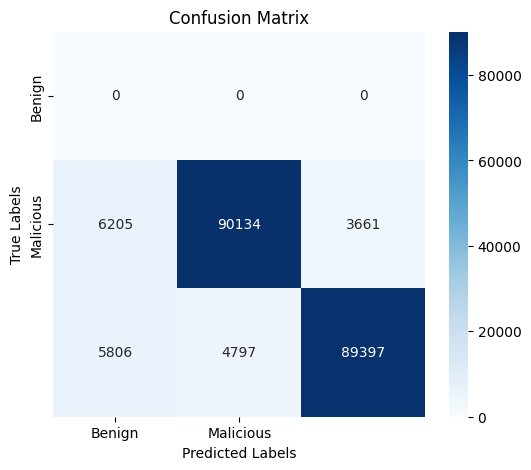

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Print the classification report for model evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [21]:
import sys
sys.path.append('./ember/ember')  # Make sure to replace with your path
from features import PEFeatureExtractor  # Or the correct function/class

file_path = "C:/Windows/winhlp32.exe"

def extract_ember_features(file_path):
    # Initialize the feature extractor
    extractor = PEFeatureExtractor()  # If it's a class
    # Read the EXE file as bytes
    with open(file_path, 'rb') as f:
        bytez = f.read()
    # Extract the feature vector
    feature_vector = extractor.feature_vector(bytez)

    return feature_vector

f = extract_ember_features(file_path)
# Print the resulting feature vector
print("Feature vector:", f)


Feature vector: [0.4363607  0.00878906 0.00423177 ... 0.         0.         0.        ]


In [ ]:
prediction = model.predict(f.reshape(1, -1))  # Reshaping to match input shape

print("Prediction (0: benign, 1: malicious):", prediction)


Prediction (0: benign, 1: malicious): [0.]
